# Batch Uncorrelated Multioutput QEP

## Introduction

This notebook demonstrates how to wrap uncorrelated QEP models into a convenient Multi-Output QEP model.
It uses batch dimensions for efficient computation. Unlike in the [Multitask QEP Example](./Multitask_QEP_Regression.ipynb), this do not model correlations between outcomes, but treats outcomes independently.

This type of model is useful if 
- when the number of training / test points is equal for the different outcomes
- using the same covariance modules and / or likelihoods for each outcome

For non-block designs (i.e. when the above points do not apply), you should instead use a `ModelList` QEP as described in the [ModelList multioutput example](./ModelList_QEP_Regression.ipynb).

In [1]:
import math
import torch
import qpytorch
from matplotlib import pyplot as plt

%matplotlib inline


[KeOps] Warning : There were warnings or errors :
/bin/sh: brew: command not found

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.
[KeOps] Warning : OpenMP library 'libomp' not found.
[KeOps] Warning : OpenMP support is not available. Disabling OpenMP.


### Set up training data

In the next cell, we set up the training data for this example. We'll be using 100 regularly spaced points on [0,1] which we evaluate the function on and add Gaussian noise to get the training labels.

We'll have two functions - a sine function (y1) and a cosine function (y2).

For MTGPs, our `train_targets` will actually have two dimensions: with the second dimension corresponding to the different tasks.

In [2]:
train_x = torch.linspace(0, 1, 100)

train_y = torch.stack([
    torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
    torch.cos(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
], -1)

## Define a batch QEP model

The model should be somewhat similar to the `ExactQEP` model in the [simple regression example](../01_Exact_QEPs/Simple_QEP_Regression.ipynb).
The differences:

1. The model will use the batch dimension to learn multiple uncorrelated QEPs simultaneously.
1. We're going to give the mean and covariance modules a `batch_shape` argument. This allows us to learn different hyperparameters for each model.
1. The model will return a `MultitaskMultivariateQExponential` distribution rather than a `MultivariateQExponential`. We will construct this distribution to convert the batch dimensions into distinct outputs.

In [3]:
POWER = 1.0
class BatchUncorrelatedMultitaskQEPModel(qpytorch.models.ExactQEP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.power = torch.tensor(POWER)
        self.mean_module = qpytorch.means.ConstantMean(batch_shape=torch.Size([2]))
        self.covar_module = qpytorch.kernels.ScaleKernel(
            qpytorch.kernels.RBFKernel(batch_shape=torch.Size([2])),
            batch_shape=torch.Size([2])
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return qpytorch.distributions.MultitaskMultivariateQExponential.from_batch_qep(
            qpytorch.distributions.MultivariateQExponential(mean_x, covar_x, power=self.power)
        )


likelihood = qpytorch.likelihoods.MultitaskQExponentialLikelihood(num_tasks=2, power=torch.tensor(POWER))
model = BatchUncorrelatedMultitaskQEPModel(train_x, train_y, likelihood)

### Train the model hyperparameters

In [4]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 80


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes QExponentialLikelihood parameters

# "Loss" for QEPs - the marginal log likelihood
mll = qpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

Iter 1/80 - Loss: 2.087
Iter 2/80 - Loss: 2.044
Iter 3/80 - Loss: 1.996
Iter 4/80 - Loss: 1.943
Iter 5/80 - Loss: 1.886
Iter 6/80 - Loss: 1.826
Iter 7/80 - Loss: 1.763
Iter 8/80 - Loss: 1.699
Iter 9/80 - Loss: 1.634
Iter 10/80 - Loss: 1.574
Iter 11/80 - Loss: 1.520
Iter 12/80 - Loss: 1.474
Iter 13/80 - Loss: 1.437
Iter 14/80 - Loss: 1.406
Iter 15/80 - Loss: 1.379
Iter 16/80 - Loss: 1.355
Iter 17/80 - Loss: 1.332
Iter 18/80 - Loss: 1.311
Iter 19/80 - Loss: 1.290
Iter 20/80 - Loss: 1.271
Iter 21/80 - Loss: 1.252
Iter 22/80 - Loss: 1.232
Iter 23/80 - Loss: 1.213
Iter 24/80 - Loss: 1.194
Iter 25/80 - Loss: 1.175
Iter 26/80 - Loss: 1.155
Iter 27/80 - Loss: 1.135
Iter 28/80 - Loss: 1.115
Iter 29/80 - Loss: 1.095
Iter 30/80 - Loss: 1.074
Iter 31/80 - Loss: 1.053
Iter 32/80 - Loss: 1.032
Iter 33/80 - Loss: 1.010
Iter 34/80 - Loss: 0.988
Iter 35/80 - Loss: 0.966
Iter 36/80 - Loss: 0.943
Iter 37/80 - Loss: 0.921
Iter 38/80 - Loss: 0.898
Iter 39/80 - Loss: 0.875
Iter 40/80 - Loss: 0.852
Iter 41/8

### Make predictions with the model

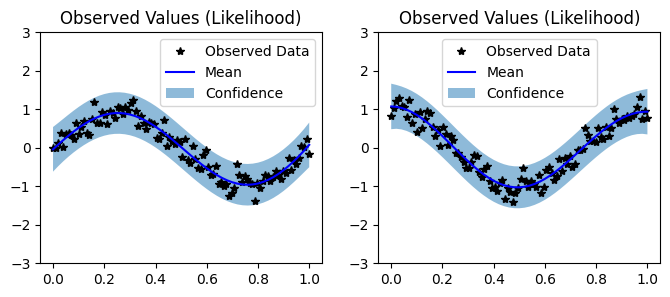

In [5]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(8, 3))

# Make predictions
with torch.no_grad(), qpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    predictions = likelihood(model(test_x))
    mean = predictions.mean
    lower, upper = predictions.confidence_region(rescale=True)
    
# This contains predictions for both tasks, flattened out
# The first half of the predictions is for the first task
# The second half is for the second task

# Plot training data as black stars
y1_ax.plot(train_x.detach().numpy(), train_y[:, 0].detach().numpy(), 'k*')
# Predictive mean as blue line
y1_ax.plot(test_x.numpy(), mean[:, 0].numpy(), 'b')
# Shade in confidence 
y1_ax.fill_between(test_x.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
y1_ax.set_ylim([-3, 3])
y1_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y1_ax.set_title('Observed Values (Likelihood)')

# Plot training data as black stars
y2_ax.plot(train_x.detach().numpy(), train_y[:, 1].detach().numpy(), 'k*')
# Predictive mean as blue line
y2_ax.plot(test_x.numpy(), mean[:, 1].numpy(), 'b')
# Shade in confidence 
y2_ax.fill_between(test_x.numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
y2_ax.set_ylim([-3, 3])
y2_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y2_ax.set_title('Observed Values (Likelihood)')

None